In [1]:
import sys  
sys.path.insert(0, '../src/')

from metrics import show_MSE_RMSE_MAE, soft_F_measure

In [2]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf

from sklearn import model_selection
from sklearn import preprocessing

import matplotlib.pyplot as plt 
from keras import layers
from keras.models import Sequential

#from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from sklearn import preprocessing
#import math

from skimage import feature
from skimage.filters import gaussian

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
keras.backend.clear_session()

In [5]:
filename = '../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [6]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
#WAVELET = marmousi_cube['wavelet']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']


### Parameters 

In [7]:
all_traces = np.arange(seismic.shape[1], dtype=int)
traces_marmousi2_train = np.linspace(0, seismic.shape[1]-1, 101, dtype=int)
validation_and_test = [trace for trace in all_traces if trace not in traces_marmousi2_train]
    
validation_and_test_traces = []
for trace in all_traces:
    if trace not in traces_marmousi2_train:
        validation_and_test_traces.append(trace)
    
traces_marmousi2_validation_indices = np.linspace(0, len(validation_and_test_traces)-1, 1350, dtype=int)
    
traces_marmousi2_validation = []
for index in traces_marmousi2_validation_indices:
    traces_marmousi2_validation.append(validation_and_test_traces[index])
        
traces_marmousi2_test = [trace for trace in validation_and_test if trace not in traces_marmousi2_validation]

n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)

### Normalizar Sismica

In [8]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [9]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [10]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [11]:
X_train = np.transpose(seismic_norm[:,train_wells_loc[0:50]])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc[0:50]])
X_train = np.expand_dims(X_train,axis=2)
Y_train = np.expand_dims(Y_train,axis=2)


X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=2)
Y_valid = np.expand_dims(Y_valid,axis=2)

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=2)
Y_test = np.expand_dims(Y_test,axis=2)


In [12]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (50, 2800, 1)
seismic (X_train) shape:  (50, 2800, 1)
     IP (Y_valid) shape:  (1350, 2800, 1)
seismic (X_valid) shape:  (1350, 2800, 1)
     IP (Y_test) shape:  (13601, 2800, 1)
seismic (X_test) shape:  (13601, 2800, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

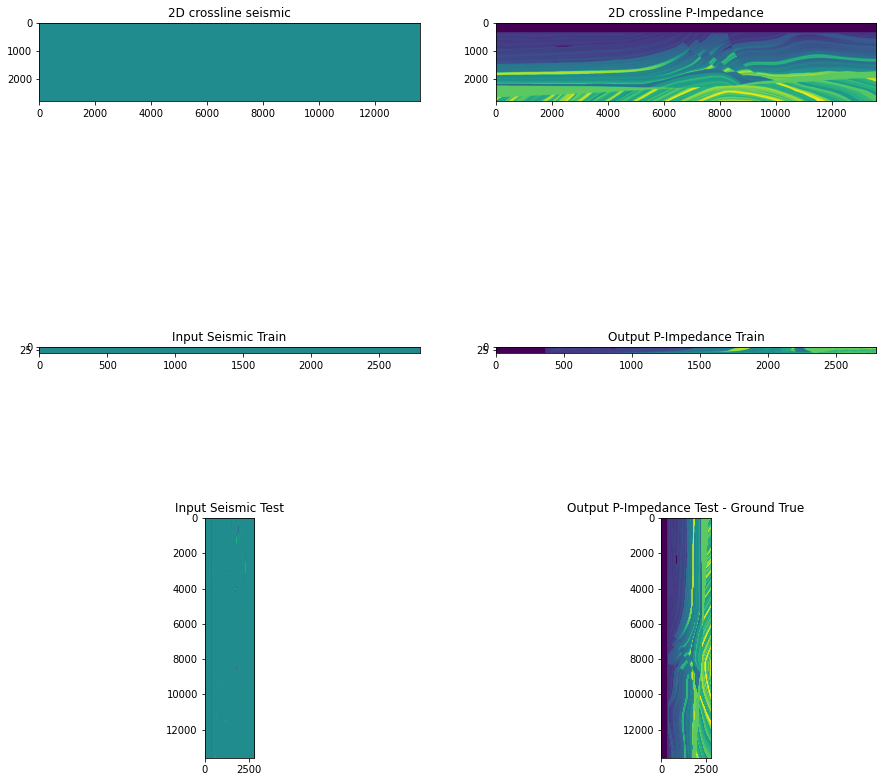

In [13]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Create and Train LSTM

### Create Net

In [14]:
num_features = 1
num_hidden_units1 = 300
num_hidden_units2 = 300
num_responses = 1
max_epochs = 1000
mini_batch_size = 10


In [15]:
callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=1, 
            patience=300)

In [16]:
model = Sequential([
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units1, return_sequences=True,), input_shape=(2800,1)),
    layers.BatchNormalization(epsilon=1e-4),
    layers.ReLU(),
    layers.Dense(150),
    layers.Dense(50),
    layers.Bidirectional(
        layers.LSTM(units=num_hidden_units2, return_sequences=True)
    ),
    layers.Dense(num_responses)
])

'''model = Sequential([
    layers.LSTM(units=numHiddenUnits1,input_shape=(700,1),return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(units=numHiddenUnits2,return_sequences=True),
    layers.Dropout(0.2),
    layers.Dense(10),
    layers.Dense(numResponses)
])'''
' '
#model.build()
#model.summary()

' '

## Treinando a Rede

In [17]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_squared_error')

Epoch 1/1000
5/5 [==============================] - 32s 7s/step - loss: 3.8043 - mean_squared_error: 3.8043 - val_loss: 0.4765 - val_mean_squared_error: 0.4765
Epoch 2/1000
5/5 [==============================] - 25s 6s/step - loss: 0.3793 - mean_squared_error: 0.3793 - val_loss: 0.0754 - val_mean_squared_error: 0.0754
Epoch 3/1000
5/5 [==============================] - 26s 6s/step - loss: 0.1063 - mean_squared_error: 0.1063 - val_loss: 0.1868 - val_mean_squared_error: 0.1868
Epoch 4/1000
5/5 [==============================] - 26s 6s/step - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 5/1000
5/5 [==============================] - 26s 6s/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0725 - val_mean_squared_error: 0.0725
Epoch 6/1000
5/5 [==============================] - 26s 6s/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0911 - val_mean_squared_error: 0.0911
Epoch 7/1000
5/5 [======================

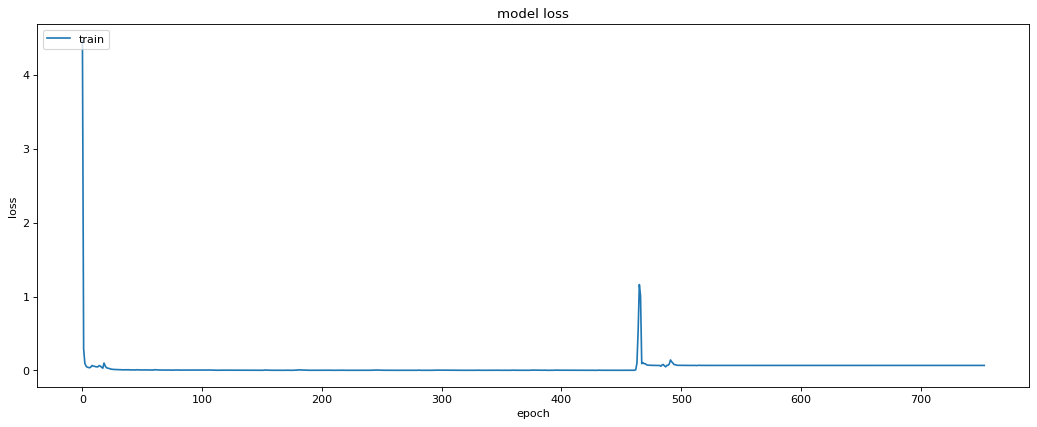

In [18]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=max_epochs,
    batch_size=mini_batch_size,
    validation_freq=1,
    shuffle=True,
    verbose=1,
    callbacks = callback
)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w')
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testando a Rede

In [19]:
X_predict = np.zeros(Y_test.shape[0:2]) 

X_predict.shape

(13601, 2800)

In [20]:
for i in range(round((X_predict.shape[0])/50)):
    start_,stop_ = (i*50),(i+1)*50
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
    #print(start_,stop_ )
    X_predict[start_:stop_,:] =model(X_test[start_:stop_,:])[:,:,0]
X_predict = np.transpose(X_predict)

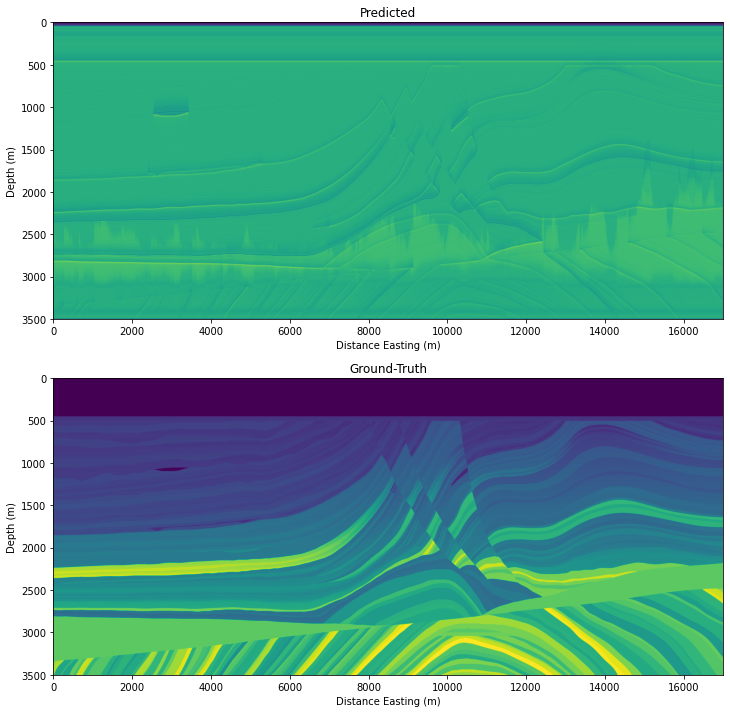

In [21]:
vmin, vmax = np.transpose(Y_test[:,:,0]).min(), np.transpose(Y_test[:,:,0]).max()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
ax1.imshow(X_predict, vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
ax1.set_aspect('auto')
ax1.set_xlabel('Distance Easting (m)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Predicted')
ax2.imshow(np.transpose(Y_test[:,:,0]), vmin=vmin, vmax=vmax, extent=(0,17000,3500,0))
ax2.set_aspect('auto')
ax2.set_xlabel('Distance Easting (m)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Ground-Truth')
plt.show()

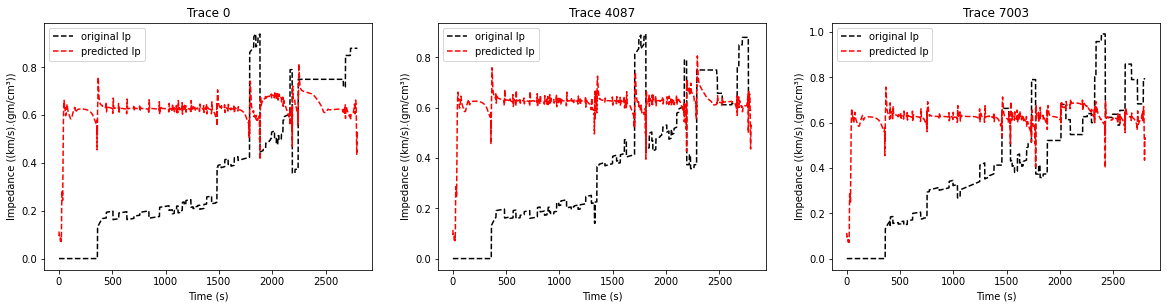

In [22]:
test_imp = Y_test[:,:,0].T

n = 3
plt.figure(figsize=(20, 10))
plot_traces = [0, 4087, 7003]
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("Trace {0}".format(plot_traces[i-1]))
    plt.plot(test_imp[:, plot_traces[i-1]], '--k')
    plt.plot(X_predict[:, plot_traces[i-1]], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()

In [24]:
AI_pred = X_predict.transpose()
AI_act = Y_test[:,:,0]

original_shape = np.expand_dims(AI_pred, axis=2)
    
pred_image = np.expand_dims(AI_pred, axis=2)
pred_image = (pred_image - np.min(pred_image)) / (np.max(pred_image) - np.min(pred_image))
pred_image = pred_image.reshape(original_shape.shape)
pred_image = (pred_image).astype('float32')
    
act_image = np.expand_dims(AI_act, axis=2)
act_image = (act_image - np.min(act_image)) / (np.max(act_image) - np.min(act_image))
act_image = act_image.reshape(original_shape.shape)
act_image = (act_image).astype('float32')
    
ssim = tf.image.ssim(act_image, pred_image, max_val=1).numpy()
print('SSIM: {:0.4f}'.format(ssim))

SSIM: 0.6122


In [27]:
from sklearn.metrics import r2_score

AI_pred_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
AI_act_partial = np.zeros((len(traces_marmousi2_test), Y_test.shape[1]))
for i in range(len(traces_marmousi2_test)):
    AI_pred_partial[i] = X_predict.transpose()[traces_marmousi2_test[i]]
    AI_act_partial[i] = Y_test[traces_marmousi2_test[i],:,0]
    
print('r^2 score: {:0.4f}'.format(r2_score(AI_act_partial.T, AI_pred_partial.T)))
print('MSE: {:0.4f}'.format(np.sum((AI_pred_partial-AI_act_partial).ravel()**2)/AI_pred_partial.size))
print('MAE: {:0.4f}'.format(np.sum(np.abs(AI_pred_partial - AI_act_partial)/AI_pred_partial.size)))
print('MedAE: {:0.4f}'.format(np.median(np.abs(AI_pred_partial - AI_act_partial))))

r^2 score: -0.7123
MSE: 0.1143
MAE: 0.2846
MedAE: 0.2678


In [30]:
model.save('saved_model/lstm_marmousi2.h5')

INFO:tensorflow:Assets written to: saved_model/lstm_marmousi2\assets


INFO:tensorflow:Assets written to: saved_model/lstm_marmousi2\assets


In [29]:
new_model = tf.keras.models.load_model('saved_model/lstm_marmousi2.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2800, 600)         724800    
_________________________________________________________________
batch_normalization (BatchNo (None, 2800, 600)         2400      
_________________________________________________________________
re_lu (ReLU)                 (None, 2800, 600)         0         
_________________________________________________________________
dense (Dense)                (None, 2800, 150)         90150     
_________________________________________________________________
dense_1 (Dense)              (None, 2800, 50)          7550      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2800, 600)         842400    
_________________________________________________________________
dense_2 (Dense)              (None, 2800, 1)           6